Text(0.5, 0.98, 'Accuracies')

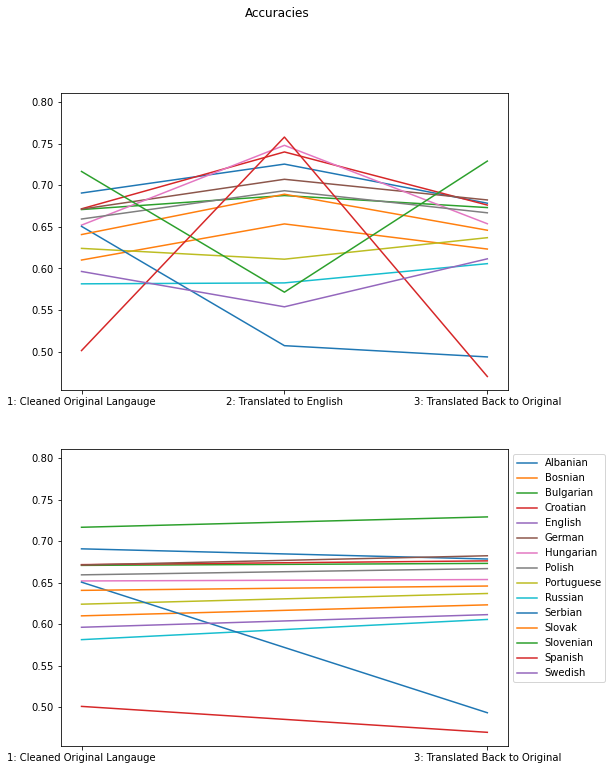

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (8,12)

pipelines = ["1: Cleaned Original Langauge", "2: Translated to English", "3: Translated Back to Original"]
data = { "Albanian" :   [0.6907679242994056, 0.7255703422053232, 0.6785111082239834],
         "Bosnian" :    [0.6101055226064854, 0.6535728130249386, 0.6233466625653645],
         "Bulgarian" :  [0.6708535739070091, 0.6877403476388247, 0.6732589348778076],
         "Croatian" :   [0.6717483751905641, 0.7402111890863776, 0.6762798239518184],
         "English" :    [0.7943662985214232, None, None],
         "German" :     [0.6713624471724693, 0.7073111488948264, 0.6824258104982556],
         "Hungarian" :  [0.6520987791961648, 0.748172757475083,  0.6537959822593269],
         "Polish" :     [0.6594672832196093, 0.6935362504232665, 0.6669599816359324],
         "Portuguese" : [0.6241413852318259, 0.6111249766019842, 0.6370149253731343],
         "Russian" :    [0.5814561714333923, 0.5825926728809885, 0.6057541957677474],
         "Serbian" :    [0.6506550218340611, 0.507029053420806,  0.4934800702857671],
         "Slovak" :     [0.6407723645292706, 0.6893227283682816, 0.6459887668706513],
         "Slovenian" :  [0.7167278316238512, 0.5714285714285714, 0.729204807768845],
         "Spanish" :    [0.5011172334725488, 0.7581346375925548, 0.46990518357629174],
         "Swedish" :    [0.5963507303089594, 0.5538045208532315, 0.6115641215715345] }
languages = list(data.keys())

fig, ax = plt.subplots(2)

for key, value in data.items():
    ax[0].plot(pipelines, value, label=key)
    
for key, value in data.items():
    ax[1].plot([pipelines[0], pipelines[2]], [value[0], value[2]], label=key)

plt.legend(bbox_to_anchor=(1, 1))
fig.suptitle('Accuracies')

In [40]:
increased = []
decreased = []
for key, value in data.items():
    if key == "English":
        continue
    if value[0] < value[2]:
        increased.append((key, value[2] - value[0]))
    else:
        decreased.append((key, value[2] - value[0]))

print("Increased between Pipeline 1 and Pipeline 3")
print(*increased, sep='\n')
print("Decreased between Pipeline 1 and Pipeline 3")
print(*decreased, sep='\n')

Increased between Pipeline 1 and Pipeline 3
('Bosnian', 0.0132411399588791)
('Bulgarian', 0.0024053609707985757)
('Croatian', 0.004531448761254331)
('German', 0.01106336332578628)
('Hungarian', 0.0016972030631621227)
('Polish', 0.0074926984163230514)
('Portuguese', 0.01287354014130837)
('Russian', 0.024298024334355017)
('Slovak', 0.005216402341380766)
('Slovenian', 0.012476976144993768)
('Swedish', 0.015213391262575149)
Decreased between Pipeline 1 and Pipeline 3
('Albanian', -0.012256816075422172)
('Serbian', -0.15717495154829397)
('Spanish', -0.031212049896257033)
